# Importing Libraries

In [46]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestRegressor
from sklearn.utils import shuffle
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedKFold
from sklearn.feature_selection import RFECV
from sklearn.preprocessing import StandardScaler 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.model_selection import RandomizedSearchCV as RCV

# Importing data and Exploratory Data Analysis

In [47]:
datas=pd.read_csv("tech_challenge2021_train.csv")
datas=datas.iloc[:,1:]
datas=shuffle(datas,random_state=101)

In [16]:
datas.isna().any()

Measured Depth m                  False
Weight on Bit kkgf                False
Average Standpipe Pressure kPa    False
Average Surface Torque kN.m       False
Rate of Penetration m/h           False
Average Rotary Speed rpm          False
Mud Flow In L/min                 False
Mud Density In g/cm3              False
Diameter mm                       False
Average Hookload kkgf             False
Hole Depth (TVD) m                False
USROP Gamma gAPI                  False
dtype: bool

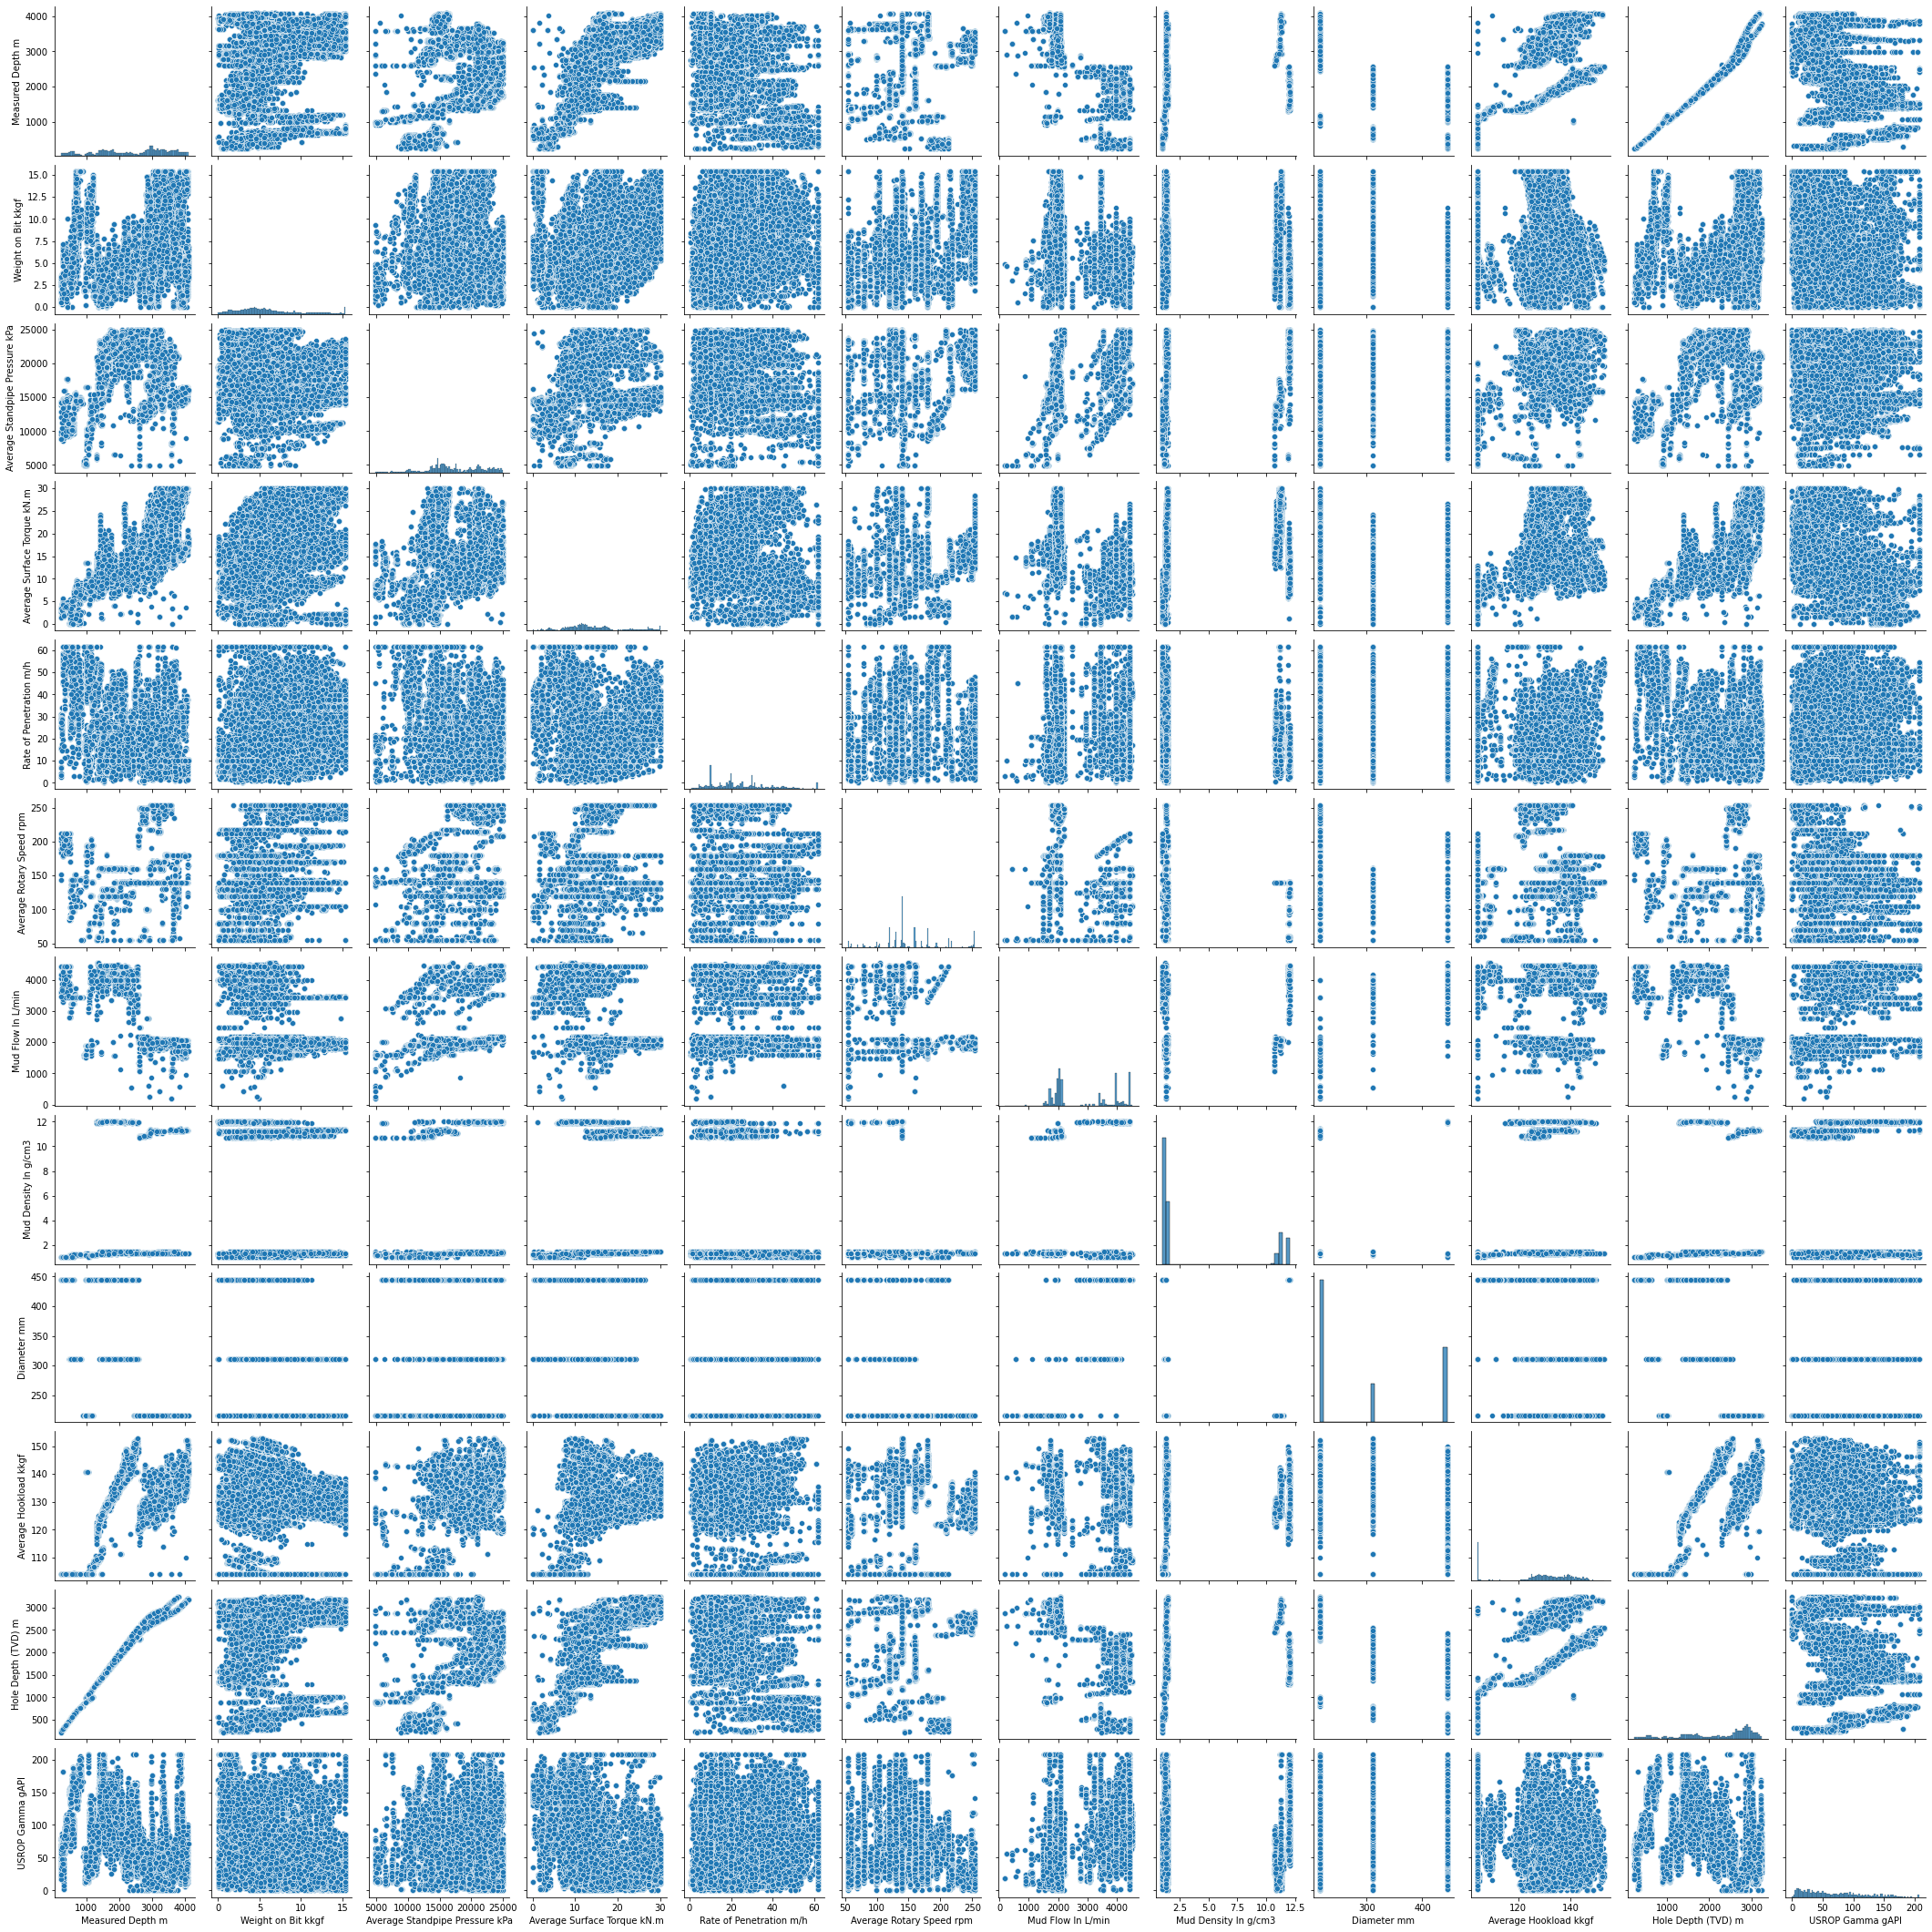

In [18]:
sns.pairplot(datas)

c:\Users\Manish\OneDrive\Desktop\ML Projects\env\lib\site-packages\pandas\plotting\_matplotlib\tools.py:331: MatplotlibDeprecationWarning: 
The is_first_col function was deprecated in Matplotlib 3.4 and will be removed two minor releases later. Use ax.get_subplotspec().is_first_col() instead.
  if ax.is_first_col():


array([[<AxesSubplot:title={'center':'Average Hookload kkgf'}>,
        <AxesSubplot:title={'center':'Average Rotary Speed rpm'}>,
        <AxesSubplot:title={'center':'Average Standpipe Pressure kPa'}>],
       [<AxesSubplot:title={'center':'Average Surface Torque kN.m'}>,
        <AxesSubplot:title={'center':'Diameter mm'}>,
        <AxesSubplot:title={'center':'Hole Depth (TVD) m'}>],
       [<AxesSubplot:title={'center':'Measured Depth m'}>,
        <AxesSubplot:title={'center':'Mud Density In g/cm3'}>,
        <AxesSubplot:title={'center':'Mud Flow In L/min'}>],
       [<AxesSubplot:title={'center':'Rate of Penetration m/h'}>,
        <AxesSubplot:title={'center':'USROP Gamma gAPI'}>,
        <AxesSubplot:title={'center':'Weight on Bit kkgf'}>]],
      dtype=object)

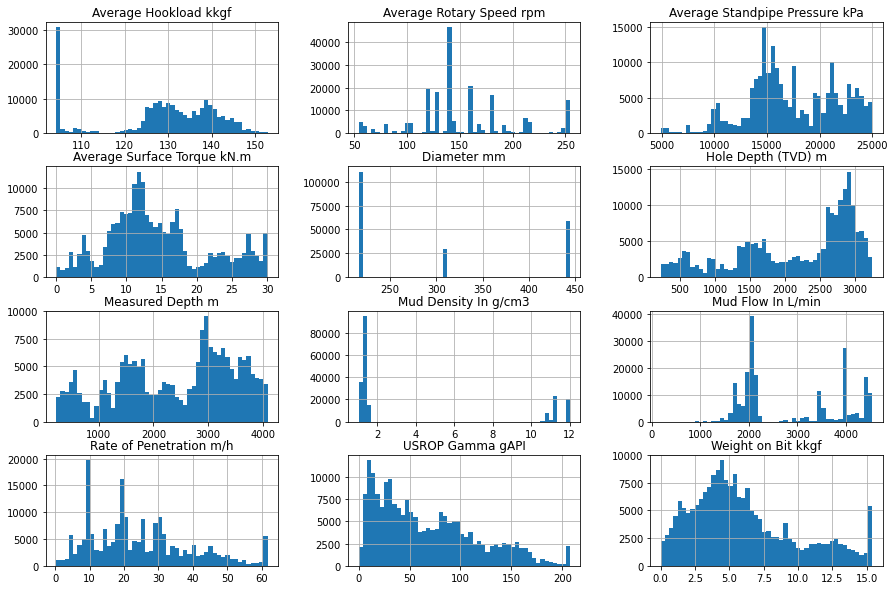

In [73]:
%matplotlib inline
datas.hist(bins=50,figsize=(15,10))

As seen from histograms the features in general are not normally distributed

In [48]:
#removing outliers
def removeOutlier(data):
    Q1 = data.quantile(0.25)
    Q3 = data.quantile(0.75)
    IQR = Q3 - Q1
    UQR=Q3+1.5*IQR
    LQR=Q1-1.5*IQR
    j=0
    for i in data.columns:
        data.loc[data[i]>UQR[j],i]=UQR[j]
        data.loc[data[i]<LQR[j],i]=LQR[j]
        j=j+1
    return data

In [49]:
# making a copy of dataset in which outliers were removed
datas1=removeOutlier(datas)

In [50]:
datas1.describe()

,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Rate of Penetration m/h,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
count,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000,198928.000000
mean,2411.781370,6.046988,17452.151863,14.401680,24.747495,152.112233,2873.576072,4.008286,297.470693,128.737614,2153.624785,66.839415
std,1066.443448,3.845913,4233.874359,7.172064,14.372501,46.877868,1055.406219,4.496288,100.344171,13.012293,846.519288,49.357095
min,225.171000,0.001814,4909.705810,0.008135,0.330000,54.200500,185.420836,1.020000,215.900000,104.234439,225.162770,0.000000
25%,1548.686750,3.283486,14655.999760,9.639866,12.990000,129.250000,1993.927917,1.300000,215.900000,124.925435,1516.593360,25.380000
50%,2697.182500,5.190356,16683.999630,12.798921,21.090000,139.736000,2121.382739,1.350000,215.900000,130.905851,2528.949222,54.490000
75%,3288.946500,8.127138,21153.529060,17.815448,32.470001,179.283000,3987.855834,10.849026,444.500000,138.719433,2865.091577,98.140000
max,4090.001000,15.392615,24998.459410,30.078821,61.690003,254.332500,4538.450195,12.017384,444.500000,152.926842,3248.389893,207.280000


In [51]:
#A function for removing highly correlated features and features which are weakly correlated to target variable
#corr_features returns correlated features whereas faet2 returns the features which are in correlation
def corrcoef(corr_matrix):
    corr_features = []
    faet2=[]
    for i in range(len(corr_matrix .columns)):
        if abs(corr_matrix.iloc[i,4])<0.10:
            corr_features.append(corr_matrix.columns[i])
        for j in range(i):
            if (j!=4):
                if abs(corr_matrix.iloc[i, j]) > 0.80:
                    colname = corr_matrix.columns[i]
                    corr_features.append(colname)
                    faet2.append(corr_matrix.columns[j])
    return corr_features,faet2

In [52]:
#spearman correlation was used as it was seen that maximum features were not linearly correlated 
corrfeat=corrcoef(datas1.corr(method='spearman'))

 Scaling is not used as Extra Trees Regressor is not affected by scaling

In [54]:
y1=datas1.loc[:,'Rate of Penetration m/h']
x2=datas1.drop(columns='Rate of Penetration m/h')
x3=x2.drop(labels=set(corrfeat[0]),axis=1)
X_train1,X_test1,y_train1,y_test1=train_test_split(x3,y1,test_size=0.20,random_state=42)

# Model training and hyperparameter tuning

As all models were evaluated previously extra trees regressor performed best so it was chosen

In [55]:
params3={'n_estimators': [250,300,350,400],
'max_depth': [30,35,40,45],
'max_features':[2,4,6,7],
'min_samples_leaf':[1,2,3],
'max_samples':[0.01,0.05,0.10,0.25,0.5,0.63,0.8]}
rreg=ExtraTreesRegressor(random_state=43)
rc2 = RCV(rreg, param_distributions=params3,n_jobs=2,cv=2,scoring='neg_mean_absolute_error',verbose=2,random_state=4).fit(X_train1,y_train1)

Fitting 2 folds for each of 10 candidates, totalling 20 fits


[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  20 out of  20 | elapsed:  7.4min finished


In [56]:
rc2.best_estimator_

ExtraTreesRegressor(max_depth=40, max_features=4, max_samples=0.63,
                    n_estimators=350, random_state=43)

In [57]:
extreg=ExtraTreesRegressor(max_depth=40, max_features=4, max_samples=0.63,
                    n_estimators=350, random_state=43,n_jobs=2,verbose=1).fit(X_train1,y_train1)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    4.0s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   20.1s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:   41.1s finished


Testing model on unseen data

In [58]:
mean_absolute_error(y_test1,extreg.predict(X_test1))

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    1.5s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:    2.6s finished


0.04199429482576069

In [21]:
print(cross_val_score(extreg,X_train1,y_train1,scoring='neg_mean_absolute_error',cv=2))

[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    7.3s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   32.2s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:   57.2s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    6.2s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:   11.0s finished
[Parallel(n_jobs=2)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    8.6s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:   35.4s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:   59.6s finished
[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    1.4s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed: 

[-0.1624989  -0.16569854]


# Saving model

In [64]:
import pickle
pickle.dump(extreg, open('model.pkl', 'wb'))

In [65]:
class Model(object):
    def __init__(self, model_file):
        # Load pre-trained model from file
        self.model = pickle.load(open(model_file, 'rb'))
        
    def _preprocess(self, features):
        # Method to be run before inference. Contains things like
        # stripping unwanted columns, replacing NaNs, and scaling 
        features.fillna(0, inplace=True)
        features = features[['Measured Depth m','Weight on Bit kkgf','Average Standpipe Pressure kPa',
                             'Average Surface Torque kN.m','Average Rotary Speed rpm','Mud Flow In L/min',
                             'Mud Density In g/cm3','Diameter mm','Average Hookload kkgf','Hole Depth (TVD) m',
                             'USROP Gamma gAPI']]
        features=features.drop(labels=set(corrfeat[0]),axis=1)
        return features
        
    def predict(self, features):
        # This function takes in features in their
        # raw, unprocessed form as read from the file test.csv and
        # return predictions as an array integers of the same length
        X = self._preprocess(features)
        return self.model.predict(X)

In [66]:
model = Model('model.pkl')

# Predicting on test data

In [67]:
open_test_features = pd.read_csv('tech_challenge2021_test.csv')
open_test_features.head()

,Well Identifier,Measured Depth m,Weight on Bit kkgf,Average Standpipe Pressure kPa,Average Surface Torque kN.m,Average Rotary Speed rpm,Mud Flow In L/min,Mud Density In g/cm3,Diameter mm,Average Hookload kkgf,Hole Depth (TVD) m,USROP Gamma gAPI
0,TC-2021-TW,365.150,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.124187,20.774
1,TC-2021-TW,365.303,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.276587,20.774
2,TC-2021-TW,365.455,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.428682,20.774
3,TC-2021-TW,365.608,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.581082,20.774
4,TC-2021-TW,365.760,10.656246,23053.9448,22.631313,169.781,3491.436904,1.31,254.0,136.662392,365.733178,20.774


In [68]:
test_prediction = model.predict(open_test_features)

[Parallel(n_jobs=2)]: Using backend ThreadingBackend with 2 concurrent workers.
[Parallel(n_jobs=2)]: Done  46 tasks      | elapsed:    0.1s
[Parallel(n_jobs=2)]: Done 196 tasks      | elapsed:    0.6s
[Parallel(n_jobs=2)]: Done 350 out of 350 | elapsed:    1.0s finished


In [72]:
test_prediction

array([28.94561872, 28.94561872, 28.94561872, ..., 21.49798663,
       21.49798663, 21.49798663])

In [74]:
!pip freeze > requirements.txt